In [1]:
import numpy as np
import pandas as pd
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util,os,time
from matplotlib.lines import Line2D
import matplotlib as mpl
import warnings, sys
warnings.filterwarnings('ignore')

In [2]:
# functions
def load_data(fname):
    npzfile = np.load(fname)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2']
    Xv_test = npzfile['arr_3']
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    X_train = list()
    X_train.append(Xh_train)
    X_train.append(Xv_train[:,8:])
    X_test = list()
    X_test.append(Xh_test)
    X_test.append(Xv_test[:,8:])
    Y_train = Y_train.astype(np.float32).reshape((-1,1))
    Y_test = Y_test.astype(np.float32).reshape((-1,1))
    return X_train, X_test, Y_train, Y_test

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def is_odd(num):
    return num & 0x1

def get_dist_inner_loop(x):
    '''for distances'''
    s,x2,f_dist,k = x
    tmp = []
    for t in x2:
        if s=='' or t=='':
            tmp.append(np.nan)
        else:
            tmp.append(f_dist(s,t,k))
    return tmp #np.argmax(tmp) ## return distance or closest train idx

def get_dist_k_parallel(x1,x2,f_dist,k,output='argman'):
    # parallelized version
    ncores = mp.cpu_count()
    dist = []
    with mp.Pool(processes=ncores) as p:
        args = [(s,x2,f_dist,k) for s in x1]
        dist.append(p.map(get_dist_inner_loop,args))
    return dist

def makeNucSeq(input):
    # input is whole Xhot array
    bases = np.array(['N','A','C','G','T'])
    output = []
    for i in input:
        tmp = np.concatenate([np.zeros((i.shape[0],1)),i],axis=1).astype('bool')
        output.append(''.join(bases[np.argmax(tmp,axis = 1)]))
    return output

def seq_ratio(s1,s2,k):
    return lv.ratio(s1,s2)

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 

def reverse_complement(seq):    
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases

reverse_complement('ATGC')

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))

def zscore(x):
    x = np.transpose(x)
    #z = stats.zscores(x)
    z = (x-np.mean(x,axis=0))/np.std(x,axis=0)
    return np.transpose(z)

def gc_content(x):
    return np.mean([int(xx in ['G','C']) for xx in x])

def T_richness(x):
    '''T-richness in TSS to TATA region,
    ~150 bp from TTT in promoter'''
    return (x.apply(lambda x: x[limits[0][1]-150:limits[0][1]])
            .apply(lambda x: x.count('T')/len(x))
           )
def atg_5utr(x):
    '''check for premature ATG in 5UTR,
    count ATG exact mathces in 5utr sequence'''
    return (x.apply(lambda x: x[limits[1][0]:limits[1][1]])
            .apply(lambda x: x.count('ATG'))
           )

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
def get_rsd(x):
    return x.std()/x.mean()


In [3]:
# data params
folder = '../data/'
names_plot = ['Promoter','5UTR','3UTR','Terminator']
limits = np.array([[0,400],[400,500],[500,750],[750,1000]])
label_names =["0_none", "1_low", "2_medium", "3_high"]
lmbda = 0.22
corrf = stats.spearmanr
x_iters = [1000,10000,30000,100000,200000,300000,500000,700000,900000,'test']
n_samples = 64
cols_to_plot = ['isValid','isPadded','seqid','jacc','gc','y_pred_log',
                'len_5utr','len_3utr','gc_5utr','gc_3utr',
                'nucpos_depleted','core_pass','kozak_pass',
                'polyat_3utr_pass','posit_3utr_pass','effic_3utr_pass',
                't_richness','atg_5utr',
                'num_motifs', 'num_tfbs', 'num_rules', 
                'coverage_motifs','coverage_tfbs','coverage_rules', 
                ]
cols_to_bar = ['isValid','isPadded',
                'core_pass','kozak_pass','atg_5utr',
                'polyat_3utr_pass','posit_3utr_pass','effic_3utr_pass',
                ]
cols_to_box = ['seqid','jacc','y_pred_log','gc','nucpos_depleted',
                'len_5utr','len_3utr','gc_5utr','gc_3utr',
                't_richness',
                'num_motifs', 'num_tfbs', 'num_rules', 
                'coverage_motifs','coverage_tfbs','coverage_rules', 
                ]


In [4]:
# load data
df = pd.read_csv(folder+'scerevisiae_tpm_full_cut5.csv')

rsd = df.groupby('gene_id').TPM.apply(get_rsd)
rsd = rsd.reset_index()
rsd.columns = ['gene_id','rsd']
df = df.merge(rsd,on='gene_id',how='left')

med = df.groupby('gene_id').TPM.median()
med = med.reset_index()
med.columns = ['gene_id','median']
df = df.merge(med,on='gene_id',how='left')

df.head()

,gene_id,sample_id,gene_len,TPM,rsd,median
0,YAL005C,SRR7242111,2313.0,973.837378,1.065374,545.49274
1,YAL005C,SRR7426367,2313.0,339.383558,1.065374,545.49274
2,YAL005C,SRR7242216,2313.0,232.165401,1.065374,545.49274
3,YAL005C,SRR3140106,2313.0,659.379465,1.065374,545.49274
4,YAL005C,SRR5448426,2313.0,337.381832,1.065374,545.49274


150493.75


<Figure size 900x900 with 0 Axes>

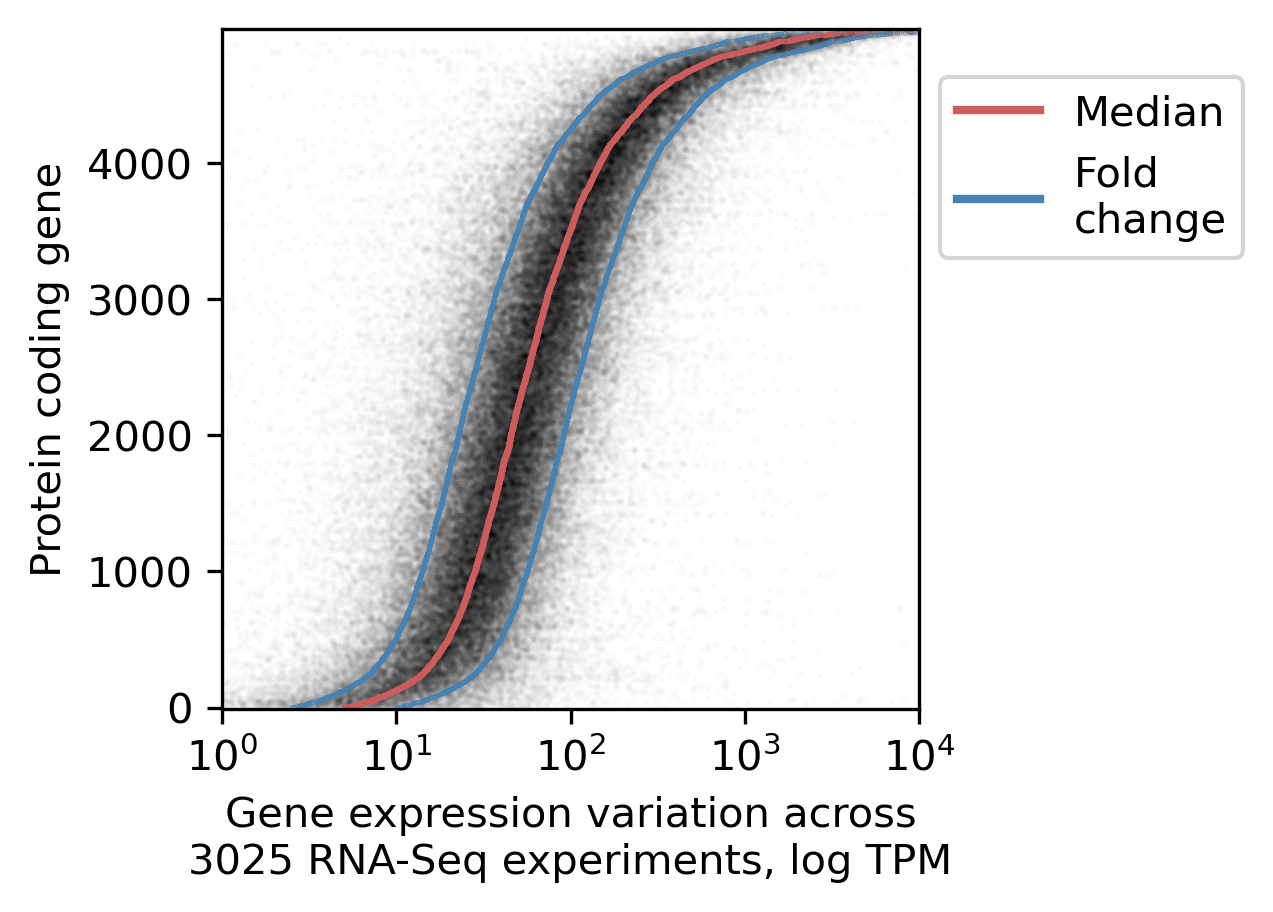

In [5]:
# gene expression training data distribution

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
print(df.shape[0]*0.01)

# rename
ren_sort = df.sort_values(by='median').gene_id.unique()
ren_dict = dict(zip(ren_sort, range(len(ren_sort))))
df['gene_num'] = df.gene_id.map(ren_dict)
med['gene_num'] = med.gene_id.map(ren_dict)

(df.sample(frac=0.01,random_state=99)
 .plot.scatter(x='TPM',y='gene_num',
               c='k',s=0.5, alpha=0.01,
               edgecolors=None,
               figsize=(3,3)
            ))
plt.scatter(med['median'],med.gene_num,color='indianred',s=0.1)
plt.scatter(med['median']*2,med.gene_num,color='steelblue',s=0.01)
plt.scatter(med['median']/2,med.gene_num,color='steelblue',s=0.01)

plt.xscale('log')
plt.xlim(1-1/2,10000+10000/2)
plt.ylim(-10,df.gene_num.max()+10)
plt.xticks([1e0,1e1,1e2,1e3,1e4])
plt.xlabel('Gene expression variation across\n3025 RNA-Seq experiments, log TPM')
plt.ylabel('Protein coding gene')

custom_lines = [Line2D([0], [0], color='indianred', lw=2),
               Line2D([0], [0], color='steelblue', lw=2)]
#plt.legend(custom_lines,['Median','Fold\nchange'],loc='lower right')
plt.legend(custom_lines,['Median','Fold\nchange'],
          bbox_to_anchor=[1,0.96])
#plt.savefig('f1b.svg')
plt.xlim(1e0,1e4)
plt.show()


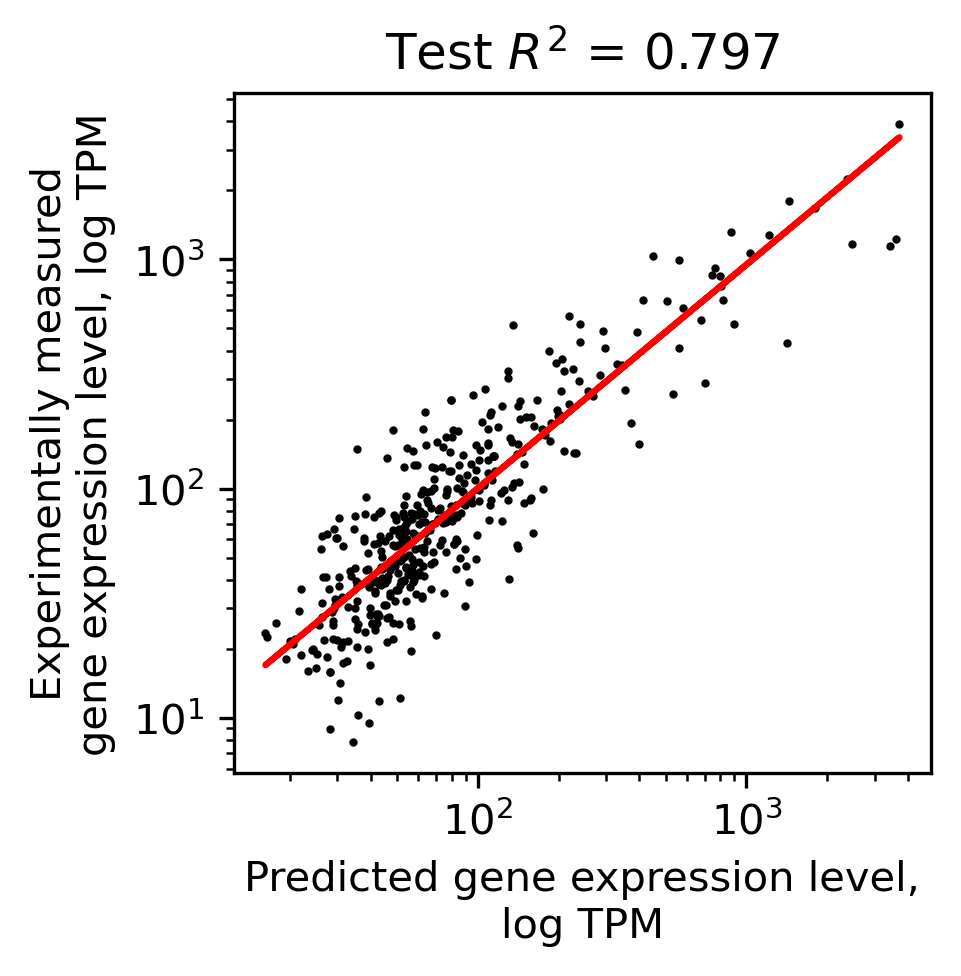

In [6]:
# plot predictor test data
_, X_test, _, Y_test = load_data(folder+'scerevisiae.rsd1.lmbda_22.1000.npz')
Y_pred = np.load(folder+'predictor_ytest_pred.npy')

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))

df_ys = pd.DataFrame([item for el in Y_test for item in el],columns=['ytrue'])
df_ys['ypred'] = [item for el in Y_pred for item in el]
df_ys.head()
r2 = coeff_determination(Y_test,Y_pred)
y = df_ys[df_ys > 0].dropna().ytrue.apply(boxtpm,lmbda=0.22).values
x = df_ys[df_ys > 0].dropna().ypred.apply(boxtpm,lmbda=0.22).values

plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
# plt.ylim(-0.001,0.1)
plt.ylabel('Experimentally measured\ngene expression level, log TPM')
plt.xlabel('Predicted gene expression level,\nlog TPM')
plt.title('Test $R^2$ = '+str("%.3f" % r2))

plt.show()

In [7]:
# load data
df_test = (pd.read_csv(folder+'Test_set_gan_metrics_df_sq91_fdr.tsv',sep='\t')
             .drop(columns=['num_motifs','num_tfbs'])
             .rename(columns={'num_seq_id':'num_motifs',
                            'num_tfbs_all':'num_tfbs',
                             })
          )
df_test['iter'] = 'test'
print(df_test.shape)

# load gen data
df_gen = (pd.read_csv(folder+'GANv2b_balanced_200d_gan_metrics_df_sq91_fdr.tsv',sep='\t')
            .drop(columns=['num_motifs','num_tfbs'])
            .rename(columns={'num_seq_id':'num_motifs',
                            'num_tfbs_all':'num_tfbs',
                            })
         )
df_gen = df_gen.sort_values(by='iter')
print(df_gen.shape)

# add metrics    
df_gen['gc_5utr'] = (df_gen.seq
                          .apply(lambda x: x[limits[1][0]:limits[1][1]].replace('N',''))
                          .apply(gc_content)
                         )
df_gen['gc_3utr'] = (df_gen.seq
                          .apply(lambda x: x[limits[2][0]:limits[2][1]].replace('N',''))
                          .apply(gc_content)
                         )
df_gen['t_richness'] = T_richness(df_gen.seq)
df_gen['atg_5utr'] =  atg_5utr(df_gen.seq)


df_test['gc_5utr'] = (df_test.seq
                          .apply(lambda x: x[limits[1][0]:limits[1][1]].replace('N',''))
                          .apply(gc_content)
                         )
df_test['gc_3utr'] = (df_test.seq
                          .apply(lambda x: x[limits[2][0]:limits[2][1]].replace('N',''))
                          .apply(gc_content)
                         )
df_test['t_richness'] = T_richness(df_test.seq)
df_test['atg_5utr'] =  atg_5utr(df_test.seq)

# log tpm
df_gen['y_pred_log'] = df_gen.y_pred.apply(lambda x: np.log10(boxtpm(x,lmbda)))
df_test['y_pred_log'] = df_test.y_pred.apply(lambda x: np.log10(boxtpm(x,lmbda)))


(425, 38)
(960, 36)


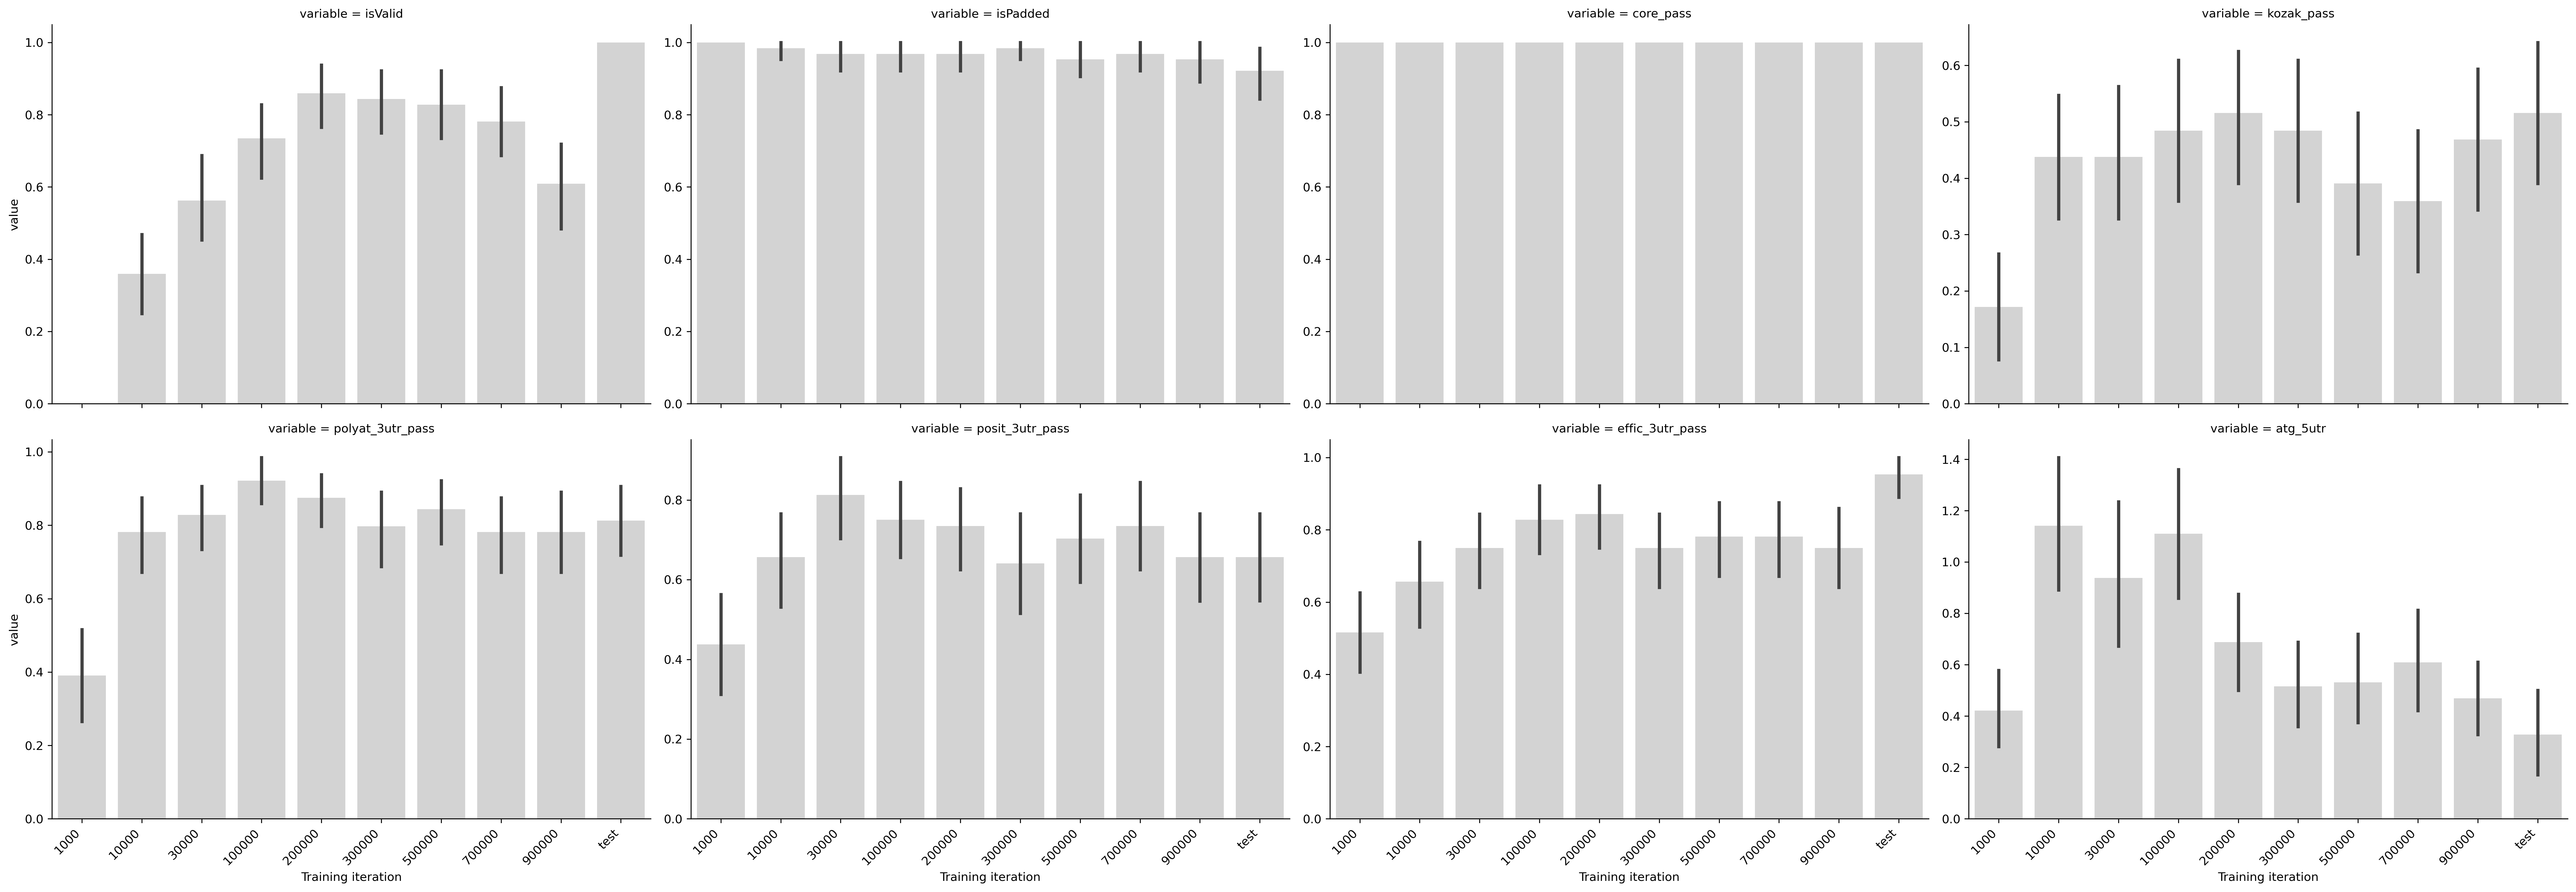

In [8]:
# plot s fig
df_plot = (df_gen
           .reset_index(drop=True)
           .append(df_test
                   .sample(n=n_samples,random_state=322)
                  )
           .query('iter.isin(@x_iters)')
           .melt(id_vars=['iter','seq'], value_vars=cols_to_plot)
          )

g = sns.catplot(data=df_plot.query('variable.isin(@cols_to_bar)'),
                color='lightgrey',
            x='iter',y='value',
            col='variable',col_wrap=4,
            kind='bar',sharey=False,
            aspect=1.5)
[ax.set_xlabel('Training iteration') for ax in g.axes.flat[-4:]]
[plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
plt.show()

g = sns.catplot(data=df_plot.query('variable.isin(@cols_to_box)'),
              color='lightgrey',
            x='iter',y='value',
            col='variable',col_wrap=4,
            kind='box',sharey=False,
            aspect=1.5)
[ax.set_xlabel('Training iteration') for ax in g.axes.flat[-4:]]
[plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
plt.show()


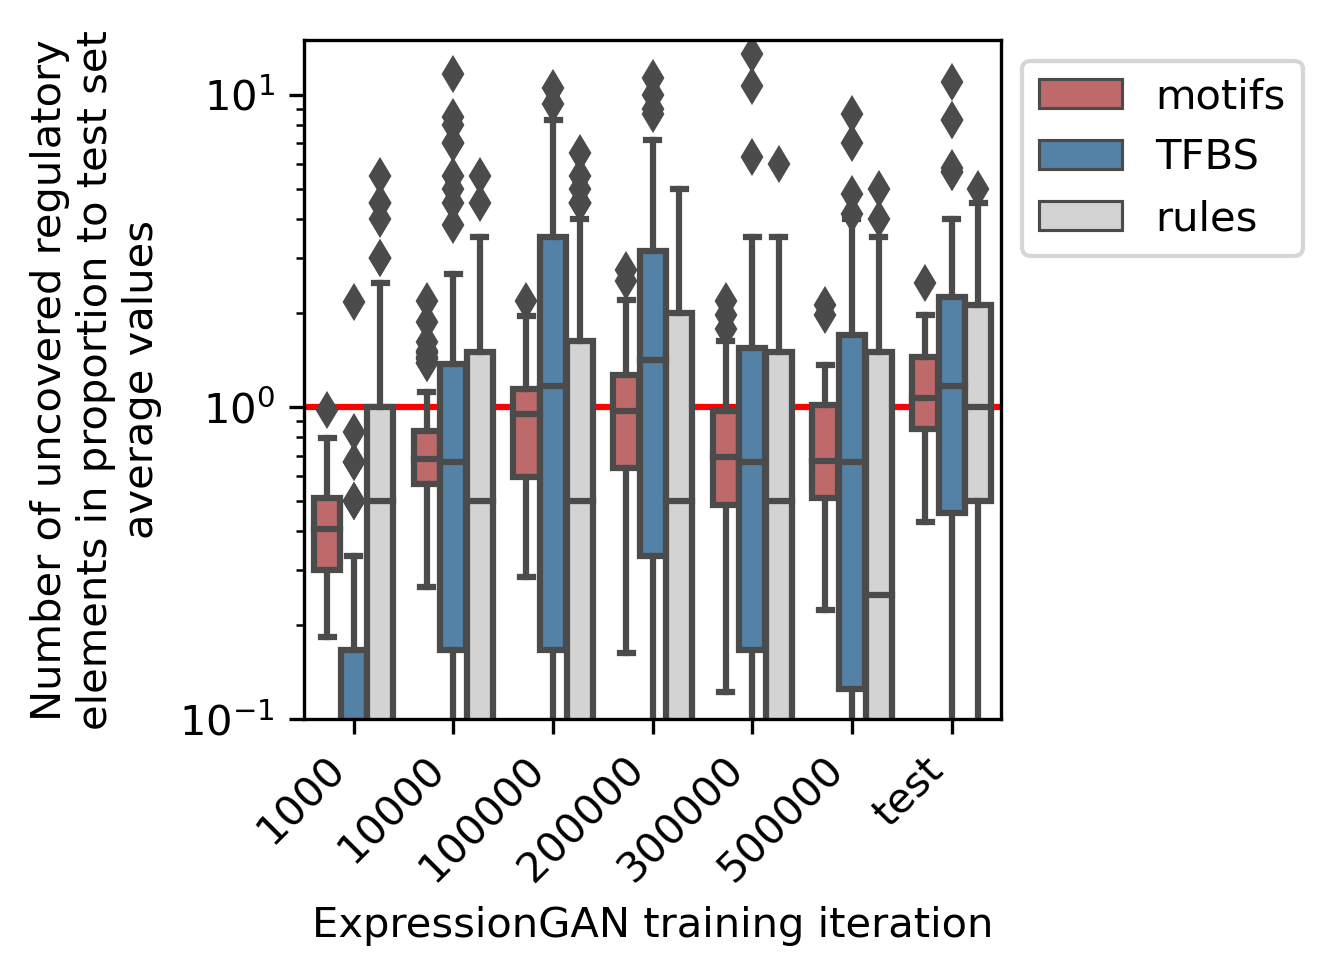

In [9]:
# num uncovered elements

di={"num_motifs":'motifs',"num_tfbs":'TFBS',"num_rules":'rules'}
di.keys()
df_test[list(di.keys())].median()

df_plot['value'] = df_plot.value.astype(float)

df_plot2 = df_plot.query('variable.isin(@di.keys())')

df_plot2['avg_value'] = (df_plot
                         .query('variable.isin(@di.keys())')
                         .set_index('variable')
                         .value
                         .divide(df_test[list(di.keys())].median())
                         .values
                        )

df_test[list(di.keys())].describe()

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data=df_plot2
            .replace({'variable':di})
            .query('iter.isin([1000,10000,100000,200000,300000,500000,"test"])'),
                hue='variable',
            x='iter',y='avg_value',
           palette=['indianred','steelblue','lightgrey'])
plt.plot([-1,10],[1,1],'r',zorder=0)
plt.yscale('log')
plt.legend(title='', bbox_to_anchor=(1,1))
plt.xlim(-0.5,6.5)
plt.ylim(1e-1,15)
plt.xticks(rotation=45,ha='right')
plt.ylabel('Number of uncovered regulatory\nelements in proportion to test set\naverage values')
plt.xlabel('ExpressionGAN training iteration')
plt.show()

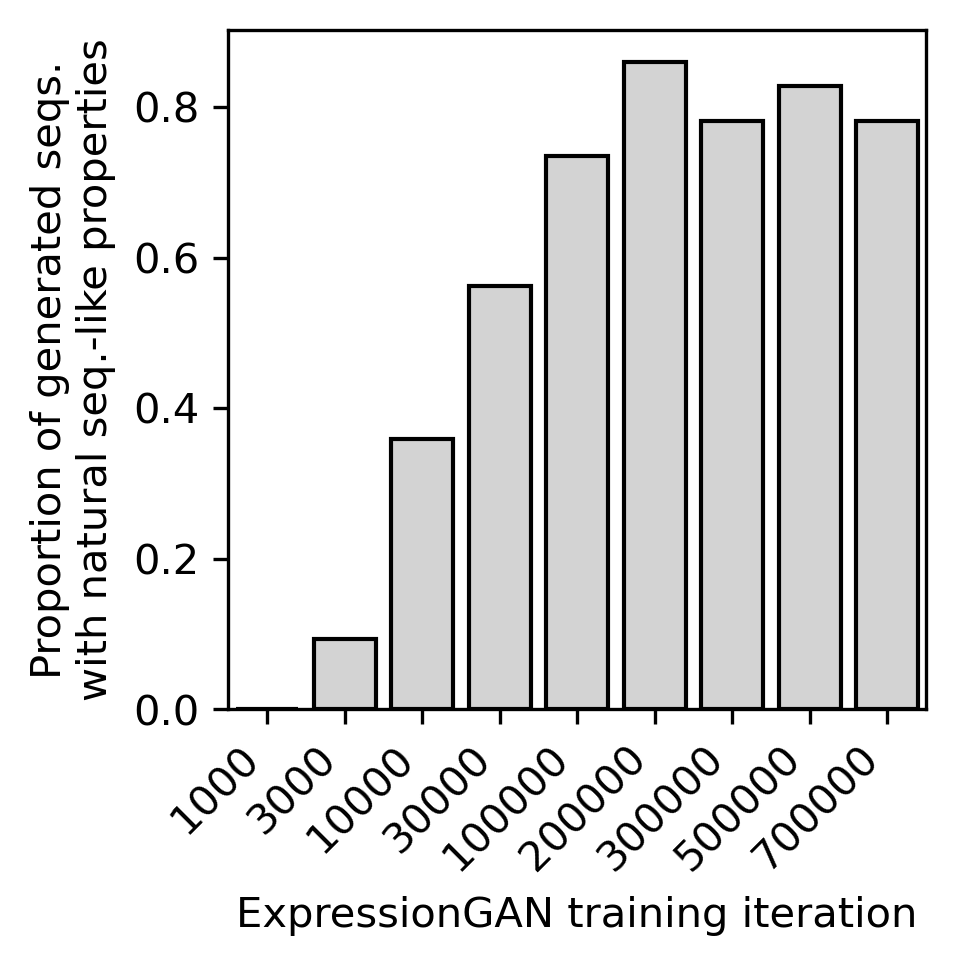

In [10]:
# how many seqs correspond to test sequence values in sample

df_plot = []
for itr in df_gen.iter.unique():
    tmp = []
    df_test_smpl = df_test.sample(n=n_samples,random_state=322)
    for idx,row in df_gen.query('iter==@itr').iterrows():
        for col in cols_to_plot:
            if (row[col] >= df_test_smpl[col].min() and 
               row[col] <= df_test_smpl[col].max()):
                   tmp.append([idx,col,1])
            else:
                tmp.append([idx,col,0])

    tmp = pd.DataFrame(tmp,columns=['idx','col','value']).set_index(['idx','col']).unstack()
    df_plot.append([itr,(tmp.sum(axis=0).min())/n_samples])

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
ax = sns.barplot(data=pd.DataFrame(df_plot,columns=['iter','var'])
            .query('iter.isin([1000,3000,10000,30000,100000,200000,300000,500000,700000])')
            ,
           x='iter',y='var',color='lightgrey',
          )
plt.xlabel('ExpressionGAN training iteration')
plt.ylabel('Proportion of generated seqs.\nwith natural seq.-like properties')
plt.xticks(rotation=45,ha='right')
for xx in ax.patches:
    xx.set_edgecolor('k')
plt.show()


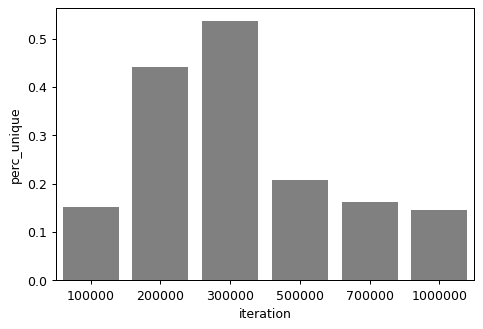

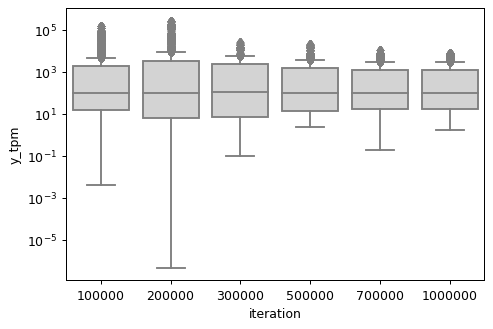

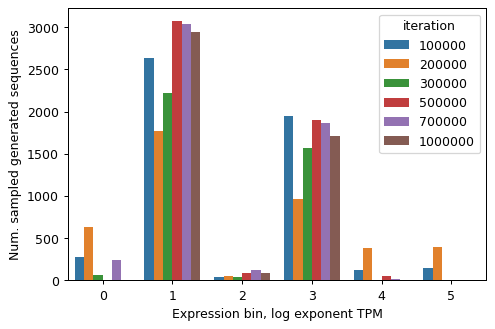

In [11]:
# How many unique sequences overall can be produced

df = pd.read_csv(folder+'dframe_optimization_200d_bal_first_64.csv')
df_unique = []
for mod in df.model.unique():
    #print(df[df.model==mod].seq.unique().shape)
    df_unique.append([mod,df[df.model==mod].seq.unique().shape[0]])
df_unique = pd.DataFrame(df_unique,columns=['iteration','num_unique'])
df_unique['perc_unique'] = df_unique.num_unique.divide(df.groupby('model').count().seq.iloc[0])

mpl.rcParams['figure.dpi'] = 90
sns.barplot(data=df_unique,
            x='iteration',y='perc_unique',
           color='grey')
plt.show()

# Plot distributions
sns.boxplot(data=df,x='model',y='y_tpm',
           color='lightgrey')
plt.yscale('log')
plt.xlabel('iteration')
plt.show()

tmp = []
for mod in df.model.unique():
    # store df
    tmp.append([5,mod,df[(df.model==mod)&(df.y_tpm>0.9e5)].shape[0]])
    tmp.append([4,mod,df[(df.model==mod)&(df.y_tpm>0.9e4)&(df.y_tpm<1.1e4)].shape[0]])
    tmp.append([3,mod,df[(df.model==mod)&(df.y_tpm>0.9e3)&(df.y_tpm<1.1e3)].shape[0]])
    tmp.append([2,mod,df[(df.model==mod)&(df.y_tpm>0.9e2)&(df.y_tpm<1.1e2)].shape[0]])
    tmp.append([1,mod,df[(df.model==mod)&(df.y_tpm>0.9e1)&(df.y_tpm<1.1e1)].shape[0]])
    tmp.append([0,mod,df[(df.model==mod)&(df.y_tpm<1.1e0)].shape[0]])
    
df_bins = (pd.DataFrame(tmp,columns=['exp_bin','iterations','num_seqs'])
            .rename(columns={'iterations':'iteration'})
          )
sns.barplot(data=df_bins,x='exp_bin',
           y='num_seqs',hue='iteration')
plt.xlabel('Expression bin, log exponent TPM')
plt.ylabel('Num. sampled generated sequences')
plt.show()


<Figure size 270x270 with 0 Axes>

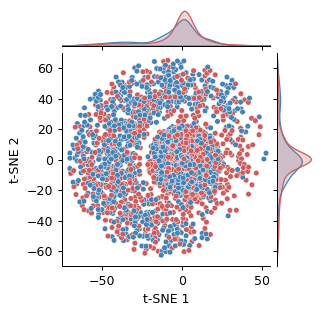

In [12]:
# TSNE on distance matrix

df_all = pd.read_csv(folder+'tsne_p100_distmat_10668.csv')
n = 2000
df_plot = df_all.query('type=="generated"').sample(n=n,random_state=33)
df_plot = df_plot.append(df_all.query('type=="natural"').sample(n=n,random_state=44))                         

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(3,3))
g = sns.jointplot(data=df_plot.sample(frac=1,random_state=55)
                  .rename(columns={'tsne1':'t-SNE 1',
                                  'tsne2':'t-SNE 2'
                                  }),
                x='t-SNE 1',y='t-SNE 2',alpha=1,
              hue='type',
              hue_order=['generated','natural'],
              palette=['indianred','steelblue'],
                  height=3.6, 
                  legend = False,
                  s=20              
                 )

g.ax_marg_x.set_xlim(-75,55)
g.ax_marg_y.set_ylim(-70,70)
plt.show()


(640, 36)
(425, 41)
(1065, 41)


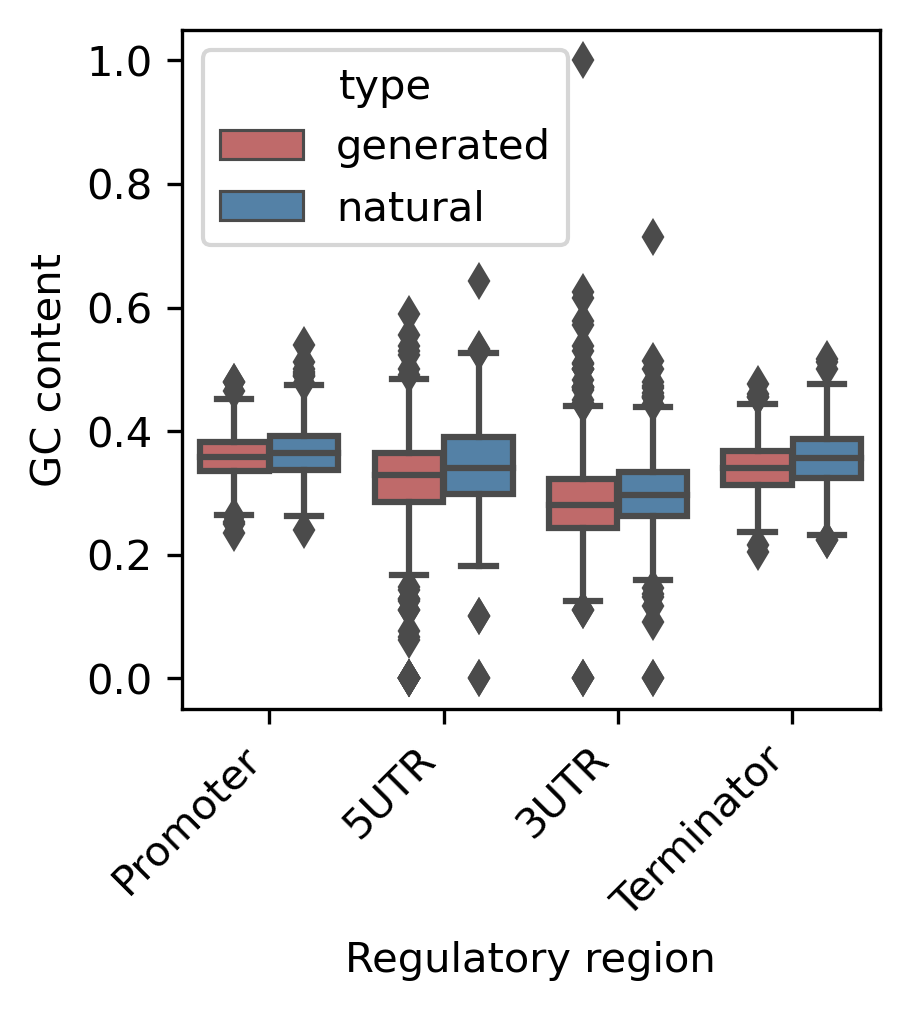

0.011499999999999955


In [13]:
# GC per region

# load
df_test = pd.read_csv(folder+'Test_set_gan_metrics_df_sq91_fdr.tsv',sep='\t')
df_test['type'] = 'natural'
df_200k_gen = pd.read_csv(folder+'metrics_200d_bal_i200k_640_sq91_fdr.tsv',sep='\t')
df_200k_gen['type'] = 'generated'
print(df_200k_gen.shape)
print(df_test.shape)
df_comb = df_200k_gen.append(df_test)
print(df_comb.shape)

df_comb['gc_prom'] = df_comb.seq.apply(lambda x: gc_content(x[:400].replace('N','')))
df_comb['gc_5utr'] = df_comb.seq.apply(lambda x: gc_content(x[400:500].replace('N','')))
df_comb['gc_3utr'] = df_comb.seq.apply(lambda x: gc_content(x[500:750].replace('N','')))
df_comb['gc_term'] = df_comb.seq.apply(lambda x: gc_content(x[750:].replace('N','')))

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data=df_comb.melt(id_vars=['type'],value_vars=['gc_prom',
                                                           'gc_5utr',
                                                           'gc_3utr',
                                                           'gc_term',
                                                          ]),
           x='variable',y='value',hue='type',
           palette=['indianred','steelblue','lightgrey'])
plt.xticks(ticks=[0,1,2,3],
           labels=['Promoter','5UTR','3UTR','Terminator'],
           rotation=45,ha='right'
          )
plt.xlabel('Regulatory region')
plt.ylabel('GC content')
plt.show()

# text values
tmp = (df_comb.melt(id_vars=['type'],
              value_vars=['gc_prom',
                           'gc_5utr',
                           'gc_3utr',
                           'gc_term',
                          ])
 .groupby('type')
 .value.median()
)
print(tmp.iloc[1]-tmp.iloc[0])

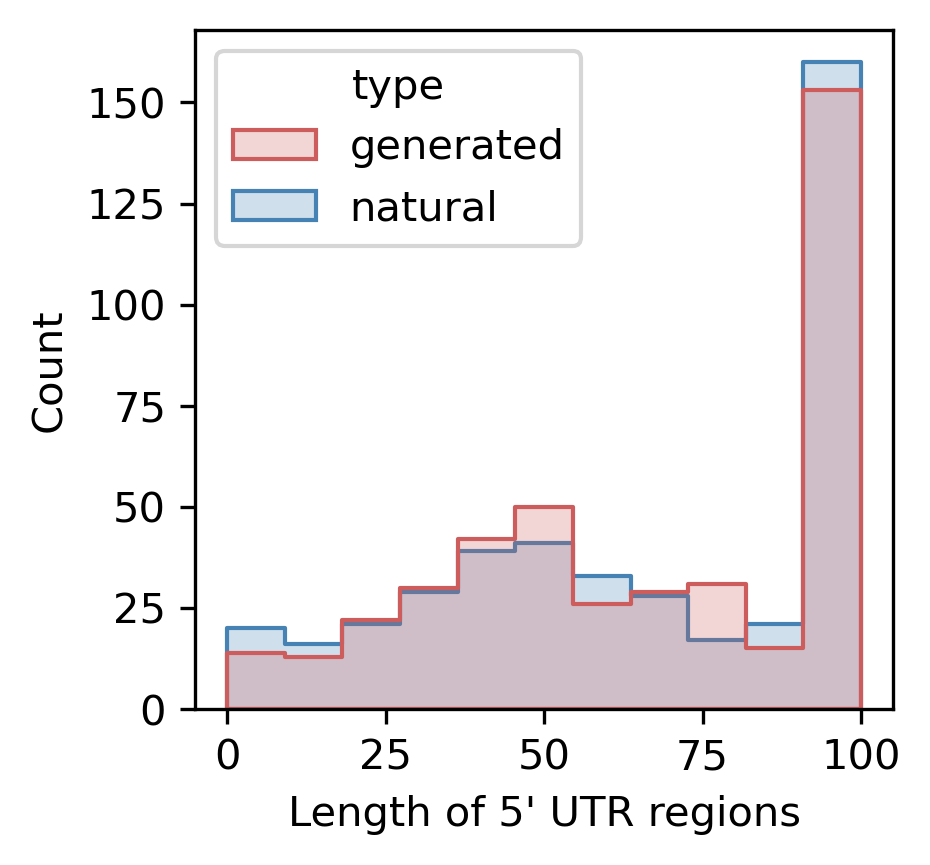

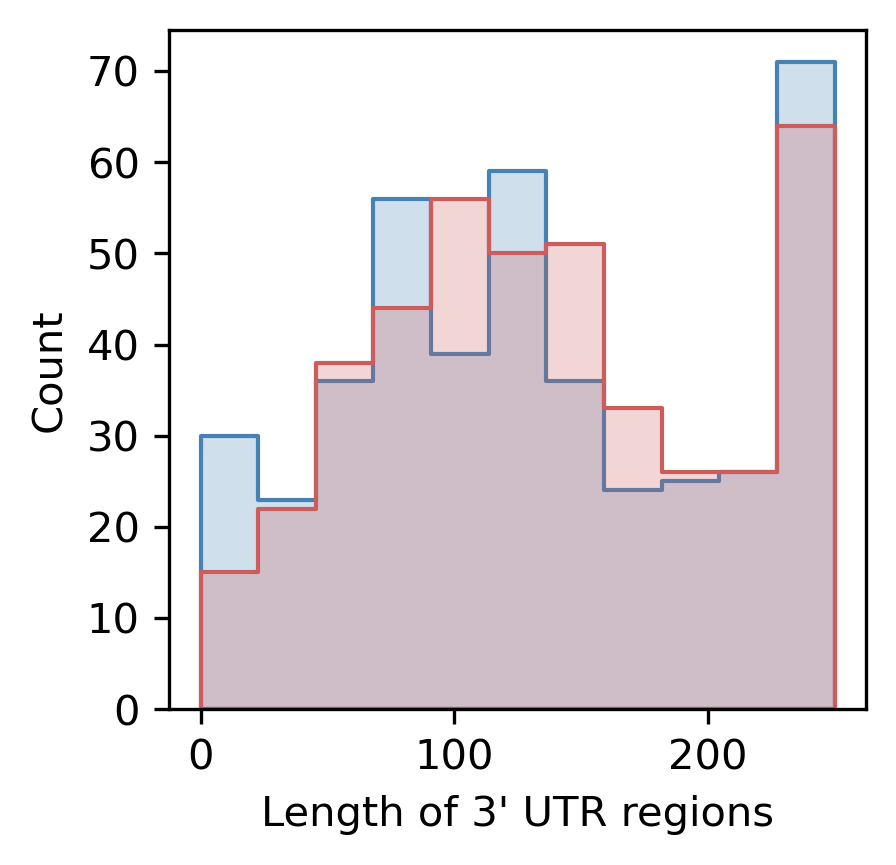

           len_5utr  len_3utr
type                         
generated        69       130
natural          66       122


In [14]:
# UTR lengths

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
ax = sns.histplot(data=df_comb[['type','len_5utr']]
             .groupby('type')
             .sample(n=df_comb.query('type=="natural"').shape[0],
                                     random_state=333),
             x='len_5utr',hue='type',
             palette=['indianred','steelblue'],
             element="step",
             legend=True,
            )
plt.xlabel("Length of 5' UTR regions")
move_legend(ax, "upper left")
plt.show()

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.histplot(data=df_comb[['type','len_3utr']]
             .groupby('type')
             .sample(n=df_comb.query('type=="natural"').shape[0],
                                     random_state=333),
             x='len_3utr',hue='type',
             palette=['indianred','steelblue'],
             element="step",
             legend=False,
            )
plt.xlabel("Length of 3' UTR regions")
plt.show()

# values text
print(df_comb[['type','len_3utr','len_5utr']]
             .groupby('type')
             .sample(n=df_comb.query('type=="natural"').shape[0],
                                     random_state=333)
 .groupby('type')
 ['len_5utr','len_3utr']
 .median()
)

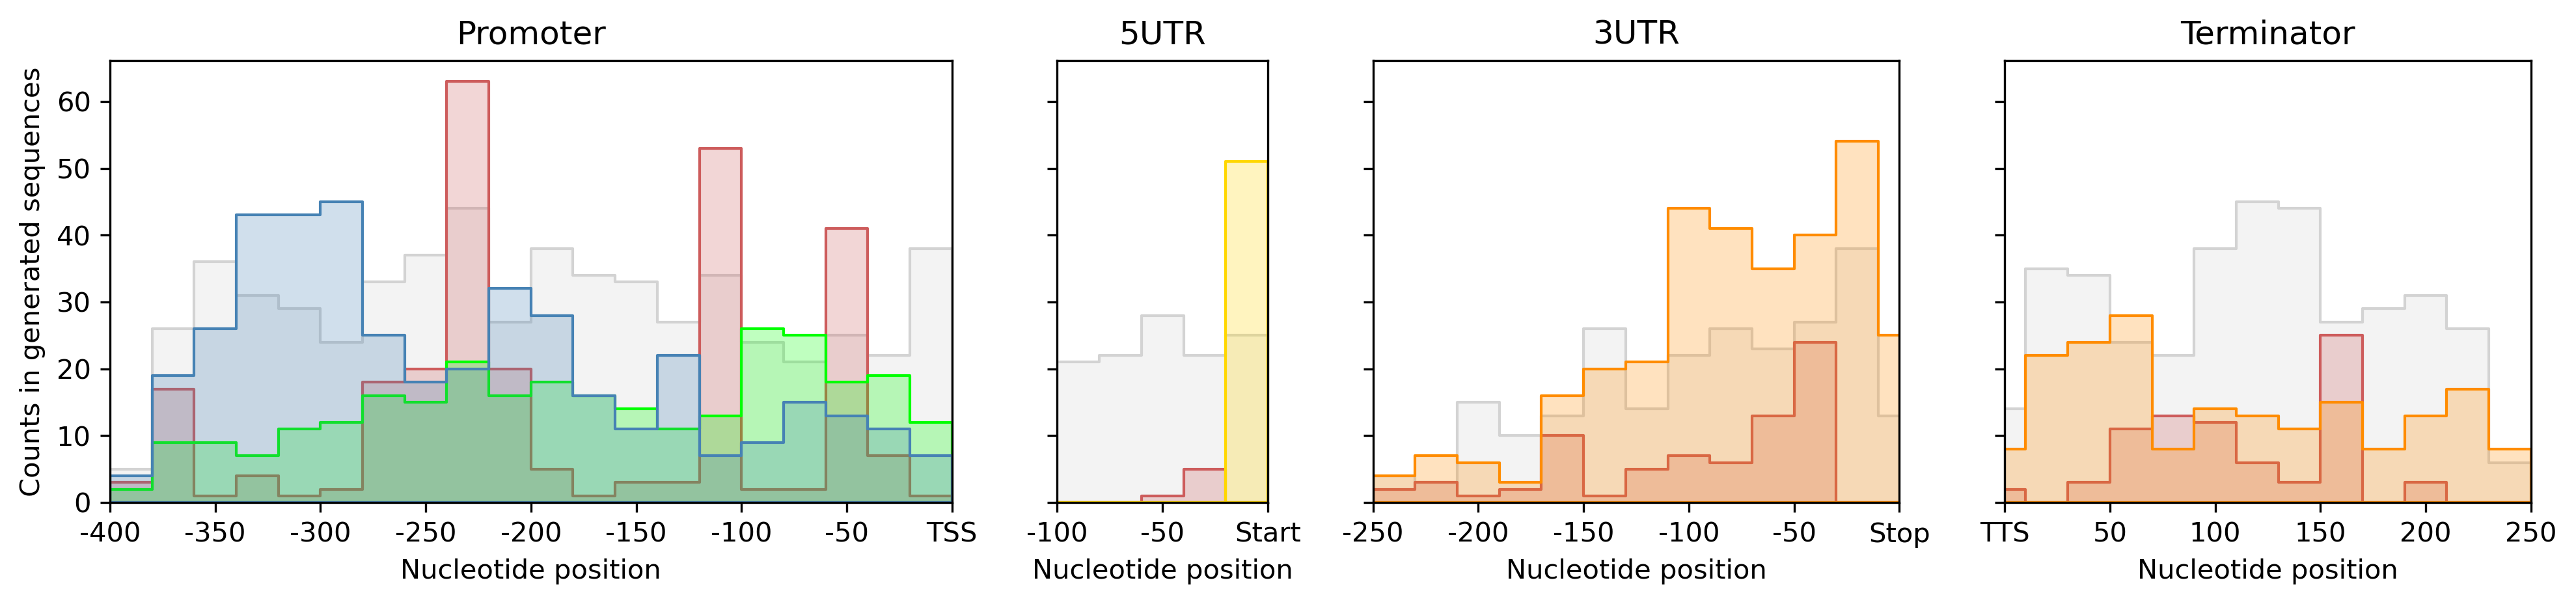

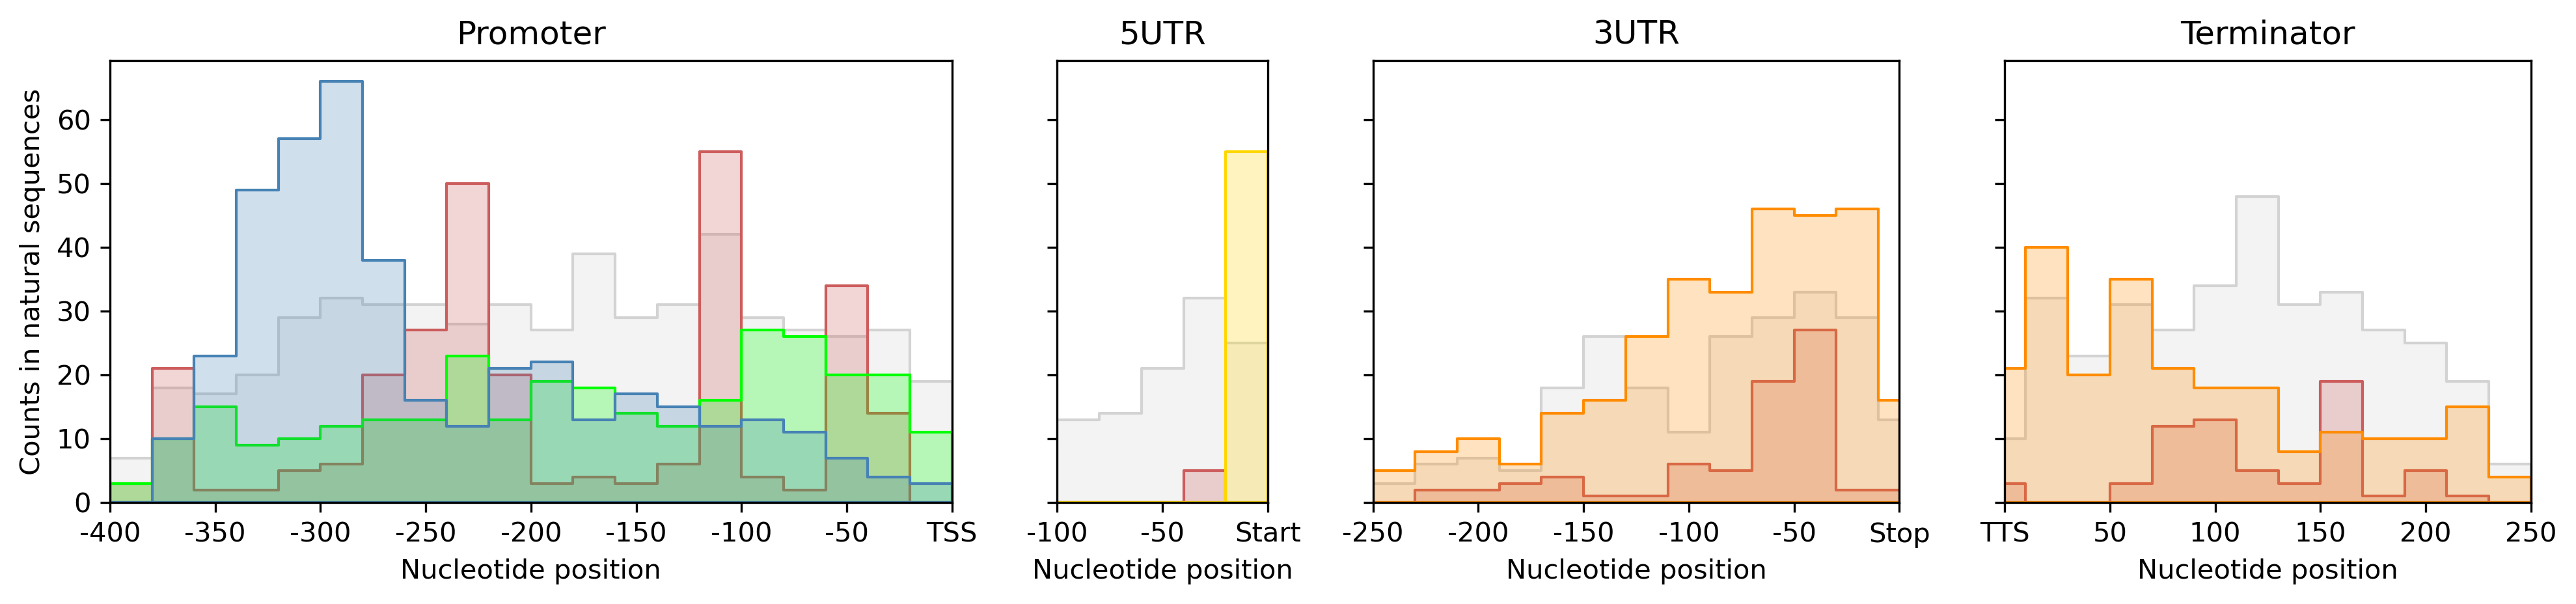

In [15]:
# separate axes plot
df_2a = pd.read_csv(folder+'data_gen_nat_motifs_filt.tsv',sep='\t')

legend_names = {'TFBS':'TFBS',
                'Core':'Core',
                'Kozak':'Kozak',
                'Term_motifs':'Termination',
                'Motifs':'Motifs_rules',
                'Nucpos':'Nuc_depleted'
               }
pal = ['steelblue',
       'lime',
       'gold',
       'darkorange',
       'indianred',
       'lightgrey']

# map elements to color
pal_dic = dict(zip(legend_names.values(),pal))

mpl.rcParams['figure.dpi'] = 300
window = 0

for typ in ['generated','natural']:
    f2 = plt.figure(figsize=(16,3))
    axarr2 = f2.subplots(1,4, sharey=True, gridspec_kw={'width_ratios': [4, 1, 2.5, 2.5]})

    for i in range(len(limits)):
        tmp1 = limits[i][0]
        tmp2 = limits[i][1]

        dat = (df_2a
         .query('type==@typ')
         .replace({'element':legend_names})
         .query('pos>=@tmp1')
         .query('pos<@tmp2')
        )
        
        sns.histplot(data=dat,
                 x='pos',hue='element',
                 element="step",
                 legend=False,
                 bins=50, binrange=[0,1000],
                 palette=[pal_dic[x] for x in dat.element.unique()],
                 ax=axarr2[i],
                )

        axarr2[i].set_title(names_plot[i])
        axarr2[i].set_xlabel('Nucleotide position')
        axarr2[i].set_xlim([limits[i][0],limits[i][1]])
        
        if i == 0:
            axarr2[i].set_ylabel('Counts in '+typ+' sequences')

    # fix coordinates
    tmp = [str(x) for x in list(range(-400,0,50))]
    tmp.extend(['TSS'])
    axarr2[0].set_xticklabels(tmp)

    tmp = [str(x) for x in list(range(-100,0,50))]
    tmp.extend(['Start'])
    axarr2[1].set_xticklabels(tmp)

    tmp = [str(x) for x in list(range(-250,0,50))]
    tmp.extend(['Stop'])
    axarr2[2].set_xticklabels(tmp)

    tmp = ['TTS']
    tmp.extend([str(x) for x in list(range(50,251,50))])
    axarr2[3].set_xticklabels(tmp)
    
    plt.show()
    

element
Core           0.956688
Kozak          1.152284
Motifs         1.063622
Nucpos         1.030671
TFBS           1.280452
Term_motifs    1.109785
Name: recovered, dtype: float64


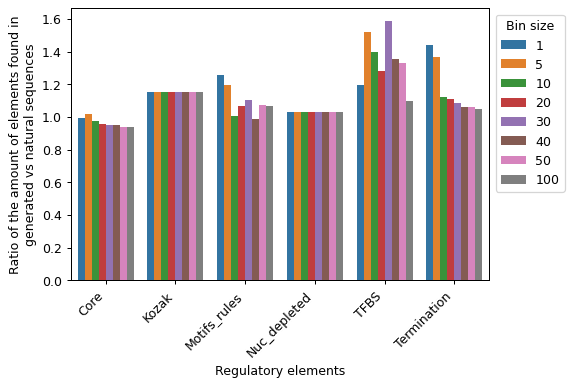

bin_size,1,5,10,20,30,40,50,100
element,,,,,,,,
Core,0.995968,1.015413,0.977070,0.956688,0.947940,0.949638,0.940598,0.940814
Kozak,1.152284,1.152284,1.152284,1.152284,1.152284,1.152284,1.152284,1.152284
Motifs,1.256124,1.193261,1.006302,1.063622,1.101100,0.989700,1.073773,1.066804
Nucpos,1.030591,1.030748,1.030929,1.030671,1.031456,1.031947,1.029698,1.026873
TFBS,1.196561,1.517544,1.397407,1.280452,1.584410,1.352120,1.329138,1.094640
Term_motifs,1.439963,1.368611,1.119695,1.109785,1.082769,1.063333,1.061015,1.047250


In [16]:
# text values
# get averages of comparison

df_2a = pd.read_csv(folder+'data_gen_nat_motifs.tsv',sep='\t')

legend_names = {'TFBS':'TFBS',
                'Core':'Core',
                'Kozak':'Kozak',
                'Term_motifs':'Termination',
                'Motifs':'Motifs_rules',
                'Nucpos':'Nuc_depleted'
               }

# bin pos into 10 bp bins
df_2a['pos_bin'] = pd.cut(df_2a.pos, 
                          bins=pd.interval_range(start=0,end=1000,periods=50)
                         )
tmp1 = (df_2a
 .query('type=="generated"')
 .groupby(['element','pos_bin'])
 .pos.count()
       )
tmp2 = (df_2a
 .query('type=="natural"')
 .groupby(['element','pos_bin'])
 .pos.count())

tmp = (tmp1[tmp1>0][tmp2>0]
       .divide(tmp2[tmp1>0][tmp2>0])
       .rename('recovered')
       .reset_index()
      )
print(tmp.groupby('element').recovered.mean())

df_plot = []
for i in [1,5,10,20,30,40,50,100]:
    df_2a['pos_bin'] = pd.cut(df_2a.pos, 
                              bins=pd.interval_range(start=0,end=1000,periods=(1000/i))
                             )
    tmp1 = (df_2a
     .query('type=="generated"')
     .groupby(['element','pos_bin'])
     .pos.count()
           )
    tmp2 = (df_2a
     .query('type=="natural"')
     .groupby(['element','pos_bin'])
     .pos.count())
    
    tmp = (tmp1[tmp1>0][tmp2>0]
           .divide(tmp2[tmp1>0][tmp2>0])
           .rename('recovered')
           .reset_index()
          )
    tmp['bin_size'] = i
    
    df_plot.append(tmp)

mpl.rcParams['figure.dpi'] = 90
sns.barplot(data=pd.concat(df_plot)
            .groupby(['element','bin_size'])
            .recovered.mean()
            .reset_index()
            .replace({'element':legend_names}),
            x='element',y='recovered',hue='bin_size'
           )
plt.ylabel('Ratio of the amount of elements found in\ngenerated vs natural sequences')
plt.xlabel('Regulatory elements')
plt.xticks(rotation=45,ha='right')
plt.legend(bbox_to_anchor=(1,1),title='Bin size')
plt.show()

(pd.concat(df_plot)
            .groupby(['element','bin_size'])
            .recovered.mean()
 .unstack()
)